# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
#!pip install gdown
import gdown

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:


file_url = 'https://drive.google.com/uc?id=1JGJI00J8X5UakRyJRAEHVYkc_CfBNBnH'

output_file = 'Train_rev1.zip'

gdown.download(file_url, output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1JGJI00J8X5UakRyJRAEHVYkc_CfBNBnH
To: /content/Train_rev1.zip
100%|██████████| 128M/128M [00:03<00:00, 41.4MB/s]


'Train_rev1.zip'

In [3]:
!unzip Train_rev1.zip

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


In [4]:
data = pd.read_csv("Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
29422,68045676,Development Geophysicist UK,SENIOR DEVELOPMENT GEOPHYSICIST LONDON UK I am...,"London, UK",London,NaN,NaN,NaN,"Energy, Oil & Gas Jobs",70000 - 110000 per annu...,90000,oilandgasjobsearch.com,11.407576
132239,70215268,CNC Miller,"Our client, an engineering company based in Ry...","Ryton, Tyne and Wear",Ryton,NaN,permanent,Quay Personnel,Engineering Jobs,11.82/hour,22694,cv-library.co.uk,10.029900
53609,68674234,Graphic Designer,Do you have a flair for design? Are you lookin...,Harrogate North Yorkshire Yorkshire,Harrogate,NaN,permanent,Invigorate Recruitment,Creative & Design Jobs,"From 14,000 to 20,000 per annum",17000,totaljobs.com,9.741028


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [5]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [6]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [7]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
# from collections import Counter
# token_counts = Counter()

# # Count how many times does each token occur in "Title" and "FullDescription"
# <YOUR CODE HERE>

In [8]:
from collections import Counter
token_counts = Counter()
for col in text_columns:
    for line in data[col]:
        token_counts.update(line.split())

In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

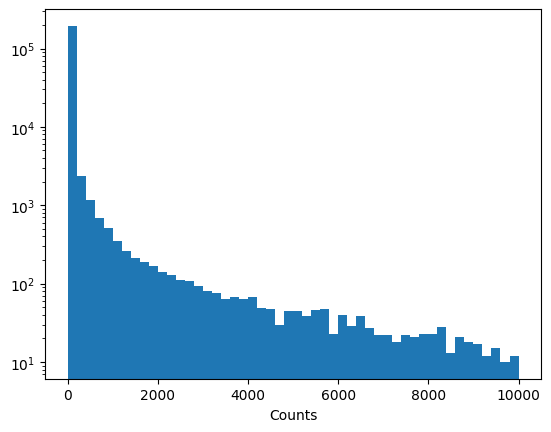

In [10]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
# min_count = 10

# # tokens from token_counts keys that had at least min_count occurrences throughout the dataset
# tokens = <YOUR CODE HERE>

# # Add a special tokens for unknown and empty words
# UNK, PAD = "UNK", "PAD"
# tokens = [UNK, PAD] + tokens

In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [12]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
# token_to_id = <your code here>

In [13]:
token_to_id = {tok: idx for idx, tok in enumerate(tokens)}

In [14]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [15]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [16]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [17]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [19]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)

    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)

    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch

In [20]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[   2,   88, 1666, 1236],
        [ 368,  386,  398,    1],
        [1724,  442,    1,    1]], dtype=int32),
 'FullDescription': array([[19899,  2574,   558,   559,    55,   142,  1497,    86,  2454,
          2497],
        [11097,    74,   368,   228,   344,   345,   368,   386,   398,
           820],
        [29808,  2319,   558,   559,  5782,    73,   247,  1036,   142,
          1724]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.71444 , 10.043293, 10.389642], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [21]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
# class TitleEncoder(nn.Module):
#     def __init__(self, n_tokens=len(tokens), out_size=64):
#         """
#         A simple sequential encoder for titles.
#         x -> emb -> conv -> global_max -> relu -> dense
#         """
#         super(self.__class__, self).__init__()
#         self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
#         self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
#         self.pool1 = GlobalMaxPooling()
#         self.dense = nn.Linear(out_size, out_size)

#     def forward(self, text_ix):
#         """
#         :param text_ix: int64 Variable of shape [batch_size, max_len]
#         :returns: float32 Variable of shape [batch_size, out_size]
#         """
#         h = self.emb(text_ix)

#         # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
#         h = torch.transpose(h, 1, 2)

#         # Apply the layers as defined above. Add some ReLUs before dense.
#         <YOUR CODE>

#         return <YOUR CODE>

In [24]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = F.relu(h)
        h = self.pool1(h)
        h = F.relu(self.dense(h))

        return h


In [23]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [ ]:
# # Define an encoder for job descriptions.
# # Use any means you want so long as it's torch.nn.Module.
# <YOUR CODE HERE>

In [25]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)  # increased embedding size for richer content
        self.conv1 = nn.Conv1d(128, out_size, kernel_size=5, padding=2)  # larger kernel size for more context
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = F.relu(h)
        h = self.pool1(h)
        h = F.relu(self.dense(h))
        return h

In [25]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
# class FullNetwork(nn.Module):
#     """
#     This class does all the steps from (title, desc, categorical) features -> predicted target
#     It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
#     """

#     def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
#         super(self.__class__, self).__init__()

#         self.title_encoder = TitleEncoder(out_size=64)
#         self.desc_encoder = <YOUR CODE>

#         # define layers for categorical features. A few dense layers would do.
#         <YOUR CODE>

#         # define "output" layers that process depend the three encoded vectors into answer
#         <YOUR CODE>


#     def forward(self, title_ix, desc_ix, cat_features):
#         """
#         :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
#         :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
#         :param cat_features: float32 Variable [batch, n_cat_features]
#         :returns: float32 Variable 1d [batch], predicted log1p-salary
#         """

#         # process each data source with it's respective encoder
#         title_h = self.title_encoder(title_ix)
#         desc_h = <YOUR CODE>

#         # apply categorical encoder
#         cat_h = <YOUR CODE>

#         # concatenate all vectors together...
#         joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

#         # ... and stack a few more layers at the top
#         <YOUR CODE>

#         # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
#         # Note 2: please do not use output nonlinearities.

#         return <YOUR CODE>

In [26]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)

        # layers for categorical features
        self.cat_block = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # output layers
        self.out_block = nn.Sequential(
            nn.Linear(64+64+64, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )


    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """

        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        # apply categorical encoder
        cat_h = self.cat_block(cat_features)

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        output = self.out_block(joint_h)

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return output[:, 0]

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [27]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [29]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [30]:
loss = compute_loss(reference, prediction).to(device)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [31]:
from tqdm.notebook import trange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]

    irange = trange if verbose else range

    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 5
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):

    print(f"Training at epoch {epoch_i} :")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction).to(device)
        loss.backward()
        opt.step()
        opt.zero_grad()

        #train_loss += loss.data.numpy()
        train_loss += loss.item()
        #train_mae += compute_mae(reference, prediction).data.numpy()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')

    print(f"Validation at epoch {epoch_i} :")
    val_loss = val_mae = val_batches = 0
    model.train(False)

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction).to(device)

            #val_loss += loss.data.numpy()
            #val_mae += compute_mae(reference, prediction).data.numpy()
            val_loss += loss.item()
            val_mae += compute_mae(reference, prediction).item()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training at epoch 0 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.52010
	MAE:	6610.22274



Validation at epoch 0 :


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.39977
	MAE:	5706.49452



Training at epoch 1 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.37589
	MAE:	5592.39683



Validation at epoch 1 :


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32135
	MAE:	5115.93959



Training at epoch 2 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.28654
	MAE:	4822.66995



Validation at epoch 2 :


  0%|          | 0/765 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7da6c72ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1278, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


	Loss:	0.28463
	MAE:	4604.18516



Training at epoch 3 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26835
	MAE:	4695.17216



Validation at epoch 3 :


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24174
	MAE:	4791.71601



Training at epoch 4 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25792
	MAE:	4552.45529



Validation at epoch 4 :


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24835
	MAE:	5232.17946





In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction).to(device)

        #val_loss += loss.data.numpy()
        #val_mae += compute_mae(reference, prediction).data.numpy()
        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24835
	MAE:	5232.17946





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order,
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

# A short report
### What we have done:
1. Early stopping
2. CNN tricks (all tricks mentioned above except that Dropout here doesn't work that much, so we abandoned it in the end.)
3. Word2vec embeddings

### What we observe:
Our intinal model performance is good while the CNN tricks improved a little. When we try the embeddings from word2vec, it did improve a lot.

But when applying CNN tricks and Embeddings, they suffer from intial drop which can be caused by initialization of weights or sth else.

Besides, since we have the data leakage problem from the beginning, it reflects on the plots.




## 1. Early stopping

Epoch 1/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	8.64524
	Train MAE:	63096.70282


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.55270
	Validation MAE:	7078.26662
Epoch 2/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.45190
	Train MAE:	6232.33924


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.37338
	Validation MAE:	5647.51814
Epoch 3/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.34545
	Train MAE:	5294.45905


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.29374
	Validation MAE:	5041.92647
Epoch 4/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.28346
	Train MAE:	5030.20964


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.25433
	Validation MAE:	4820.08700
Epoch 5/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.25969
	Train MAE:	4813.00263


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.23409
	Validation MAE:	4757.60649
Epoch 6/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.23033
	Train MAE:	4516.75452


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.23381
	Validation MAE:	5009.64530
Epoch 7/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.20938
	Train MAE:	4288.83722


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.20878
	Validation MAE:	4084.91830
Epoch 8/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.20237
	Train MAE:	4260.03563


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.19746
	Validation MAE:	4591.32469
Epoch 9/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.19348
	Train MAE:	4133.65041


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.17219
	Validation MAE:	3846.38822
Epoch 10/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.17678
	Train MAE:	4103.68631


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.15961
	Validation MAE:	3860.57683
Epoch 11/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.16759
	Train MAE:	3829.09525


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.15814
	Validation MAE:	3788.03135
Epoch 12/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.16482
	Train MAE:	3876.54374


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.17239
	Validation MAE:	4334.37974
Epoch 13/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.14821
	Train MAE:	3729.97611


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.19531
	Validation MAE:	4815.98143
Epoch 14/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.15300
	Train MAE:	3809.45423


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.14294
	Validation MAE:	3521.11143
Epoch 15/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.14747
	Train MAE:	3698.08372


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.17665
	Validation MAE:	4522.69131
Epoch 16/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13595
	Train MAE:	3569.81995


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.18721
	Validation MAE:	4840.43363
Epoch 17/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13331
	Train MAE:	3502.37825


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12827
	Validation MAE:	3343.81177
Epoch 18/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13940
	Train MAE:	3553.79611


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.15773
	Validation MAE:	4119.67649
Epoch 19/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13221
	Train MAE:	3422.22216


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.13213
	Validation MAE:	3664.01815
Epoch 20/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12248
	Train MAE:	3391.27405


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.13893
	Validation MAE:	3844.17297
Epoch 21/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13299
	Train MAE:	3471.70838


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11794
	Validation MAE:	3279.49059
Epoch 22/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12556
	Train MAE:	3481.93799


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.13989
	Validation MAE:	3444.96812
Epoch 23/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11862
	Train MAE:	3403.67128


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11469
	Validation MAE:	3281.60735
Epoch 24/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13901
	Train MAE:	3656.82306


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.16462
	Validation MAE:	3646.23732
Epoch 25/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12763
	Train MAE:	3498.89441


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.13725
	Validation MAE:	3395.48810
Epoch 26/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11817
	Train MAE:	3381.64688


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11503
	Validation MAE:	3184.69163
Epoch 27/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11308
	Train MAE:	3269.52407


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10422
	Validation MAE:	3078.57947
Epoch 28/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10489
	Train MAE:	3056.65822


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12789
	Validation MAE:	3659.39819
Epoch 29/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13297
	Train MAE:	3487.32664


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11059
	Validation MAE:	3116.77386
Epoch 30/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11191
	Train MAE:	3248.19707


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10883
	Validation MAE:	3287.46374
Epoch 31/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11106
	Train MAE:	3325.95524


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10618
	Validation MAE:	3058.62261
Epoch 32/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10788
	Train MAE:	3169.22411


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10102
	Validation MAE:	3048.44024
Epoch 33/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11495
	Train MAE:	3303.33392


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.15778
	Validation MAE:	3627.40059
Epoch 34/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10411
	Train MAE:	3054.53045


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10543
	Validation MAE:	3194.88727
Epoch 35/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11891
	Train MAE:	3411.93714


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10726
	Validation MAE:	3070.83764
Epoch 36/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10007
	Train MAE:	3084.01324


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09379
	Validation MAE:	2932.38460
Epoch 37/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09611
	Train MAE:	2984.77175


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09551
	Validation MAE:	2986.29210
Epoch 38/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09135
	Train MAE:	3014.18398


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09564
	Validation MAE:	2999.11642
Epoch 39/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09423
	Train MAE:	2893.98742


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09127
	Validation MAE:	2870.44120
Epoch 40/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10765
	Train MAE:	3158.29852


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09432
	Validation MAE:	2929.59918
Epoch 41/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11040
	Train MAE:	3160.72392


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.15282
	Validation MAE:	4282.60403
Epoch 42/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09665
	Train MAE:	2982.94324


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10506
	Validation MAE:	3034.38231
Epoch 43/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12918
	Train MAE:	3470.69607


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09461
	Validation MAE:	2902.49467
Epoch 44/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10223
	Train MAE:	2990.62438


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09183
	Validation MAE:	2933.92122
Early stopping triggered. Training stopped.


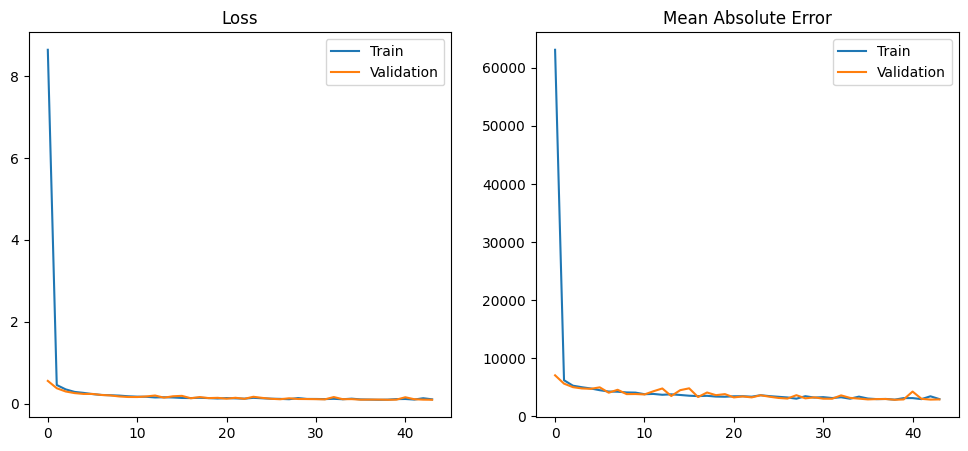

In [33]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100
early_stopping_patience = 5

train_loss_history = []
train_mae_history = []
val_loss_history = []
val_mae_history = []

best_val_mae = float('inf')
best_model_state = None
no_improvement_epochs = 0

for epoch_i in range(num_epochs):
    print(f"Epoch {epoch_i + 1}/{num_epochs} :")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1

    avg_train_loss = train_loss / train_batches
    avg_train_mae = train_mae / train_batches
    train_loss_history.append(avg_train_loss)
    train_mae_history.append(avg_train_mae)

    print("\tTrain loss:\t%.5f" % avg_train_loss)
    print("\tTrain MAE:\t%.5f" % avg_train_mae)

    # Validation
    val_loss = val_mae = val_batches = 0
    model.train(False)
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.item()
            val_mae += compute_mae(reference, prediction).item()
            val_batches += 1

    avg_val_loss = val_loss / val_batches
    avg_val_mae = val_mae / val_batches
    val_loss_history.append(avg_val_loss)
    val_mae_history.append(avg_val_mae)

    print("\tValidation loss:\t%.5f" % avg_val_loss)
    print("\tValidation MAE:\t%.5f" % avg_val_mae)

    # Early Stopping
    if avg_val_mae < best_val_mae:
        best_val_mae = avg_val_mae
        best_model_state = deepcopy(model.state_dict())

        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered. Training stopped.")
            break

model.load_state_dict(best_model_state)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_history, label='Train')
plt.plot(val_mae_history, label='Validation')
plt.title('Mean Absolute Error')
plt.legend()

plt.show()


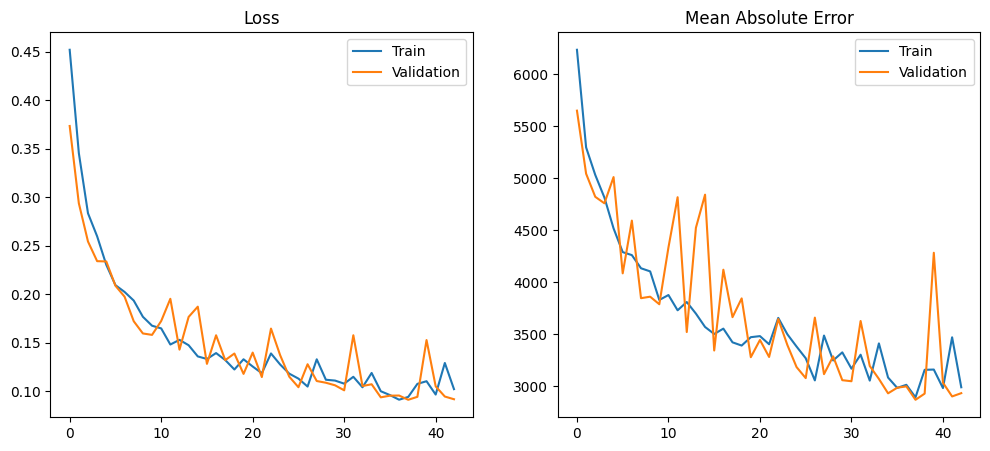

In [35]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history[1:], label='Train')
plt.plot(val_loss_history[1:], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_history[1:], label='Train')
plt.plot(val_mae_history[1:], label='Validation')
plt.title('Mean Absolute Error')
plt.legend()

plt.show()

In [34]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction).to(device)

        #val_loss += loss.data.numpy()
        #val_mae += compute_mae(reference, prediction).data.numpy()
        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09127
	MAE:	2870.44120






## 2. CNN tricks



In [ ]:
def calculate_average_lengths(data, text_columns):
    avg_lengths = {}
    for col in text_columns:
        lengths = [len(str(row).split()) for row in data[col]]
        avg_lengths[col] = np.mean(lengths)
    return avg_lengths

text_columns = ['Title', 'FullDescription']
avg_lengths = calculate_average_lengths(data_train, text_columns)
print(avg_lengths)


{'Title': 4.7050174541856, 'FullDescription': 275.9654230086567}


In [35]:
n_cat_features=len(categorical_vectorizer.vocabulary_)
n_cat_features

3768

In [36]:
n_tokens=len(tokens)
n_tokens

34158

In [51]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=4, padding=2)
        self.bn1 = nn.BatchNorm1d(out_size)
        self.bn2 = nn.BatchNorm1d(out_size)
        self.dropout = nn.Dropout(0.2)

        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size * 2, out_size)


    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        h1 = F.relu(self.bn1(self.conv1(h)))
        h2 = F.relu(self.bn2(self.conv2(h)))

        h = torch.cat((self.pool1(h1), self.pool1(h2)), dim=1)

        h = F.relu(self.dense(h))


        return h


In [52]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)

        self.conv1 = nn.Conv1d(128, out_size, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(128, out_size, kernel_size=7, padding=3)
        self.conv3 = nn.Conv1d(128, out_size, kernel_size=9, padding=4)

        self.bn1 = nn.BatchNorm1d(out_size)
        self.bn2 = nn.BatchNorm1d(out_size)
        self.bn3 = nn.BatchNorm1d(out_size)
        self.dropout = nn.Dropout(0.4)

        self.pool1 = GlobalMaxPooling()

        self.dense = nn.Linear(out_size*3, out_size)


    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)

        h1 = F.relu(self.bn1(self.conv1(h)))
        h2 = F.relu(self.bn2(self.conv2(h)))
        h3 = F.relu(self.bn3(self.conv3(h)))

        h = torch.cat((self.pool1(h1), self.pool1(h2), self.pool1(h3)), dim=1)


        h = F.relu(self.dense(h))

        return h

In [53]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)

        # layers for categorical features
        self.cat_block = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # output layers
        self.out_block = nn.Sequential(
            nn.Linear(64+64+64, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )


    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """

        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        # apply categorical encoder
        cat_h = self.cat_block(cat_features)

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        output = self.out_block(joint_h)

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return output[:, 0]

In [54]:
model_2 = FullNetwork().to(device)
opt = torch.optim.Adam(model_2.parameters(), lr=3e-3)

Epoch 1/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	6.07309
	Train MAE:	222723.21568


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	2.33447
	Validation MAE:	43505.97023
Epoch 2/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	2.74670
	Train MAE:	32018.47310


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.51321
	Validation MAE:	8553.97110
Epoch 3/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	1.34422
	Train MAE:	16929.78963


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.40294
	Validation MAE:	6733.45935
Epoch 4/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.90363
	Train MAE:	13365.95493


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.61192
	Validation MAE:	5859.69625
Epoch 5/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.53017
	Train MAE:	7464.25271


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.36331
	Validation MAE:	4904.19986
Epoch 6/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.64673
	Train MAE:	9190.95955


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.44383
	Validation MAE:	9143.84166
Epoch 7/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.39465
	Train MAE:	6622.91965


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.41324
	Validation MAE:	8620.56905
Epoch 8/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.32087
	Train MAE:	5741.60083


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.23361
	Validation MAE:	5313.20201
Epoch 9/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.25299
	Train MAE:	5129.55204


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.21784
	Validation MAE:	5089.82798
Epoch 10/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.20190
	Train MAE:	4490.82271


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.16180
	Validation MAE:	3689.65648
Epoch 11/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.18580
	Train MAE:	4234.26774


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.17880
	Validation MAE:	3788.69456
Epoch 12/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.17489
	Train MAE:	3995.10509


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.14326
	Validation MAE:	3481.08254
Epoch 13/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.16811
	Train MAE:	4013.97911


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.13831
	Validation MAE:	3429.46772
Epoch 14/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.14410
	Train MAE:	3667.17901


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12484
	Validation MAE:	3359.33104
Epoch 15/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.14667
	Train MAE:	3641.26038


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.18512
	Validation MAE:	3904.89690
Epoch 16/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.14367
	Train MAE:	3652.76639


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.14958
	Validation MAE:	3552.80968
Epoch 17/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13561
	Train MAE:	3618.53620


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.31188
	Validation MAE:	7252.23100
Epoch 18/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13431
	Train MAE:	3660.14647


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12659
	Validation MAE:	3639.64867
Epoch 19/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12141
	Train MAE:	3355.47695


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10999
	Validation MAE:	3260.81026
Epoch 20/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12579
	Train MAE:	3478.68093


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.18512
	Validation MAE:	4794.54008
Epoch 21/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12299
	Train MAE:	3463.86704


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12250
	Validation MAE:	3589.85539
Epoch 22/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13036
	Train MAE:	3583.27949


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09942
	Validation MAE:	2980.76974
Epoch 23/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11038
	Train MAE:	3254.78329


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09797
	Validation MAE:	2969.96064
Epoch 24/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12148
	Train MAE:	3472.68281


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11035
	Validation MAE:	3333.55399
Epoch 25/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11451
	Train MAE:	3350.62509


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.21862
	Validation MAE:	5615.70026
Epoch 26/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11184
	Train MAE:	3280.63731


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.15481
	Validation MAE:	3620.62070
Epoch 27/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11025
	Train MAE:	3236.46295


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10135
	Validation MAE:	3169.01265
Epoch 28/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10413
	Train MAE:	3117.21315


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.08953
	Validation MAE:	2855.47637
Epoch 29/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11112
	Train MAE:	3237.68384


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09984
	Validation MAE:	2962.84910
Epoch 30/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10478
	Train MAE:	3153.76233


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12594
	Validation MAE:	3320.11118
Epoch 31/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12841
	Train MAE:	3457.60067


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.13070
	Validation MAE:	3891.46944
Epoch 32/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10156
	Train MAE:	3162.23627


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11780
	Validation MAE:	3158.21681
Epoch 33/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11973
	Train MAE:	3305.13515


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09765
	Validation MAE:	3122.14190
Early stopping triggered. Training stopped.


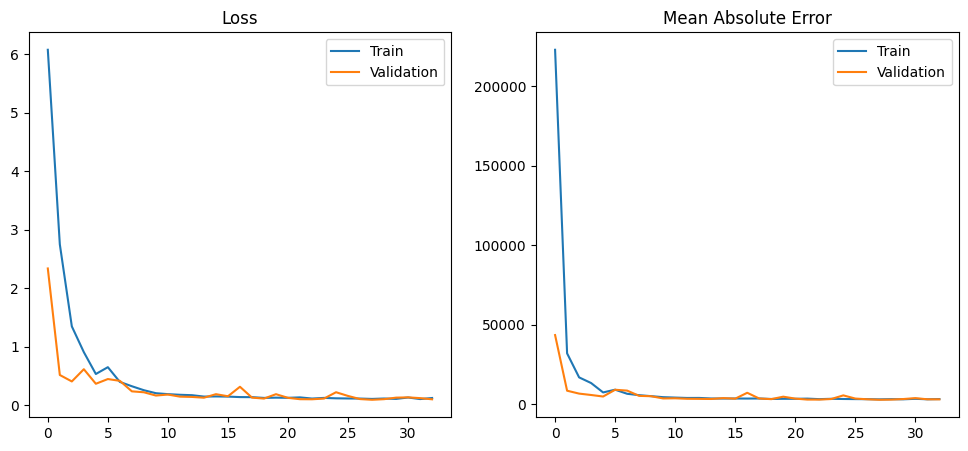

In [56]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100
early_stopping_patience = 5

train_loss_history = []
train_mae_history = []
val_loss_history = []
val_mae_history = []

best_val_mae = float('inf')
best_model_state = None
no_improvement_epochs = 0

for epoch_i in range(num_epochs):
    print(f"Epoch {epoch_i + 1}/{num_epochs} :")
    train_loss = train_mae = train_batches = 0
    model_2.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model_2(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()
        train_mae += compute_mae(reference, prediction).item()
        train_batches += 1

    avg_train_loss = train_loss / train_batches
    avg_train_mae = train_mae / train_batches
    train_loss_history.append(avg_train_loss)
    train_mae_history.append(avg_train_mae)

    print("\tTrain loss:\t%.5f" % avg_train_loss)
    print("\tTrain MAE:\t%.5f" % avg_train_mae)

    # Validation
    val_loss = val_mae = val_batches = 0
    model_2.train(False)
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model_2(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.item()
            val_mae += compute_mae(reference, prediction).item()
            val_batches += 1

    avg_val_loss = val_loss / val_batches
    avg_val_mae = val_mae / val_batches
    val_loss_history.append(avg_val_loss)
    val_mae_history.append(avg_val_mae)

    print("\tValidation loss:\t%.5f" % avg_val_loss)
    print("\tValidation MAE:\t%.5f" % avg_val_mae)

    # Early Stopping
    if avg_val_mae < best_val_mae:
        best_val_mae = avg_val_mae
        best_model_state = deepcopy(model_2.state_dict())

        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered. Training stopped.")
            break

model_2.load_state_dict(best_model_state)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_history, label='Train')
plt.plot(val_mae_history, label='Validation')
plt.title('Mean Absolute Error')
plt.legend()

plt.show()


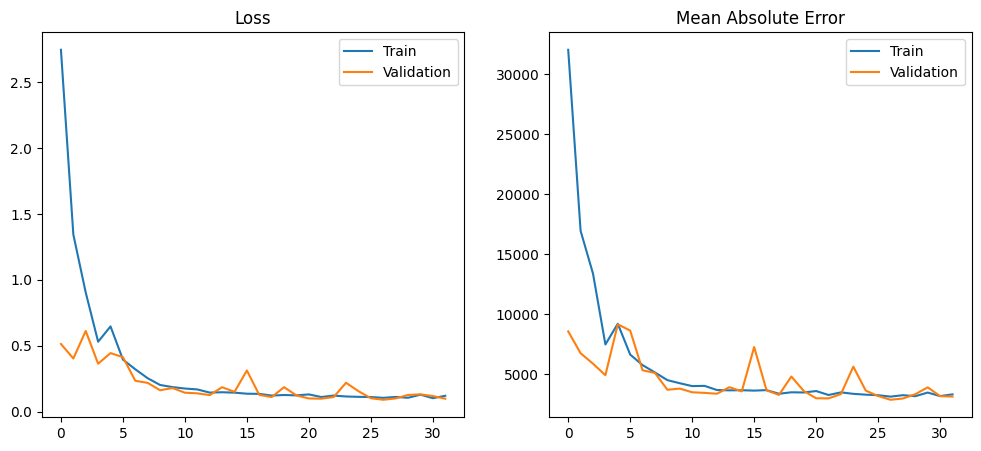

In [57]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history[1:], label='Train')
plt.plot(val_loss_history[1:], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_history[1:], label='Train')
plt.plot(val_mae_history[1:], label='Validation')
plt.title('Mean Absolute Error')
plt.legend()

plt.show()

In [58]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model_2(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction).to(device)

        #val_loss += loss.data.numpy()
        #val_mae += compute_mae(reference, prediction).data.numpy()
        val_loss += loss.item()
        val_mae += compute_mae(reference, prediction).item()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08953
	MAE:	2855.47637





## 3. Embeddings

In [32]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)


[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [33]:
import gensim

# Load Google's pre-trained Word2Vec model.
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', binary=True)


In [37]:
vocab_size = n_tokens
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word,i in token_to_id.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]


In [38]:
embedding_tensor = torch.Tensor(embedding_matrix)

In [43]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, embedding_tensor=embedding_tensor):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, embedding_tensor.size(1), padding_idx=PAD_IX)
        self.emb.weight.data = embedding_tensor
        self.emb.weight.requires_grad = False

        self.conv1 = nn.Conv1d(embedding_tensor.size(1), out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = F.relu(h)
        h = self.pool1(h)
        h = F.relu(self.dense(h))

        return h

class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, embedding_tensor=embedding_tensor):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, embedding_tensor.size(1), padding_idx=PAD_IX)
        self.emb.weight.data = embedding_tensor
        self.emb.weight.requires_grad = False

        self.conv1 = nn.Conv1d(embedding_tensor.size(1), out_size, kernel_size=5, padding=2)  # larger kernel size for more context
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = F.relu(h)
        h = self.pool1(h)
        h = F.relu(self.dense(h))
        return h

class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(embedding_tensor=embedding_tensor)
        self.desc_encoder = DescriptionEncoder(embedding_tensor=embedding_tensor)


        # layers for categorical features
        self.cat_block = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # output layers
        self.out_block = nn.Sequential(
            nn.Linear(64+64+64, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )


    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """

        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)

        # apply categorical encoder
        cat_h = self.cat_block(cat_features)

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        output = self.out_block(joint_h)

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return output[:, 0]

In [49]:
model_3 = FullNetwork().to(device)
opt = torch.optim.Adam(model_3.parameters(), lr=1e-3)

In [50]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

prediction = model_3(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

Epoch 1/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	11.12958
	Train MAE:	36207.85187


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.38891
	Validation MAE:	5656.51160
Epoch 2/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.24157
	Train MAE:	4519.50607


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.17174
	Validation MAE:	3997.65569
Epoch 3/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.16344
	Train MAE:	3810.65237


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.13849
	Validation MAE:	3604.74248
Epoch 4/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.15082
	Train MAE:	3696.87617


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12422
	Validation MAE:	3400.55343
Epoch 5/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.13144
	Train MAE:	3541.51608


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12559
	Validation MAE:	3389.27642
Epoch 6/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12363
	Train MAE:	3450.89200


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11320
	Validation MAE:	3234.02680
Epoch 7/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12499
	Train MAE:	3350.36558


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10723
	Validation MAE:	3152.01001
Epoch 8/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12006
	Train MAE:	3414.87813


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10509
	Validation MAE:	3090.51646
Epoch 9/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11143
	Train MAE:	3213.78346


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10613
	Validation MAE:	3175.58703
Epoch 10/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11288
	Train MAE:	3202.19412


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11054
	Validation MAE:	3132.96231
Epoch 11/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12068
	Train MAE:	3354.73196


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10338
	Validation MAE:	3092.34945
Epoch 12/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11294
	Train MAE:	3330.84590


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09945
	Validation MAE:	3042.13248
Epoch 13/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10974
	Train MAE:	3079.83093


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10207
	Validation MAE:	3147.55556
Epoch 14/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12265
	Train MAE:	3385.70484


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09389
	Validation MAE:	2957.57274
Epoch 15/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10019
	Train MAE:	2993.82648


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09160
	Validation MAE:	2893.81168
Epoch 16/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10552
	Train MAE:	3184.88347


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.15341
	Validation MAE:	3727.69254
Epoch 17/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10286
	Train MAE:	3022.36194


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.13008
	Validation MAE:	3435.44416
Epoch 18/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10474
	Train MAE:	3151.30122


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12286
	Validation MAE:	3312.73545
Epoch 19/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09701
	Train MAE:	3034.35907


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.08497
	Validation MAE:	2777.68533
Epoch 20/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.11277
	Train MAE:	3170.86174


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10092
	Validation MAE:	3015.24876
Epoch 21/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09348
	Train MAE:	3026.17534


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.18252
	Validation MAE:	4960.91897
Epoch 22/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.12463
	Train MAE:	3466.29348


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.15928
	Validation MAE:	4420.18776
Epoch 23/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09540
	Train MAE:	2915.96528


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.08358
	Validation MAE:	2742.61833
Epoch 24/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.08253
	Train MAE:	2795.06213


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11954
	Validation MAE:	3233.28272
Epoch 25/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09224
	Train MAE:	2966.07526


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.08143
	Validation MAE:	2722.98931
Epoch 26/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10149
	Train MAE:	3031.32882


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.11480
	Validation MAE:	3440.66149
Epoch 27/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10135
	Train MAE:	3112.12389


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.08127
	Validation MAE:	2721.98732
Epoch 28/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.10370
	Train MAE:	3069.72468


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09844
	Validation MAE:	2980.00038
Epoch 29/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09953
	Train MAE:	3070.92538


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.10884
	Validation MAE:	3371.35100
Epoch 30/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09399
	Train MAE:	2934.12436


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09220
	Validation MAE:	2960.13893
Epoch 31/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09752
	Train MAE:	3002.52255


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.07851
	Validation MAE:	2655.55314
Epoch 32/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.08777
	Train MAE:	2848.66358


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.08476
	Validation MAE:	2777.77565
Epoch 33/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.08652
	Train MAE:	2804.31221


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.08392
	Validation MAE:	2753.87076
Epoch 34/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.09732
	Train MAE:	3067.77721


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.09647
	Validation MAE:	3122.46285
Epoch 35/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.08348
	Train MAE:	2813.98226


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.07800
	Validation MAE:	2656.45825
Epoch 36/100 :


  0%|          | 0/100 [00:00<?, ?it/s]

	Train loss:	0.08929
	Train MAE:	2866.25891


  0%|          | 0/765 [00:00<?, ?it/s]

	Validation loss:	0.12312
	Validation MAE:	3356.01754
Early stopping triggered. Training stopped.


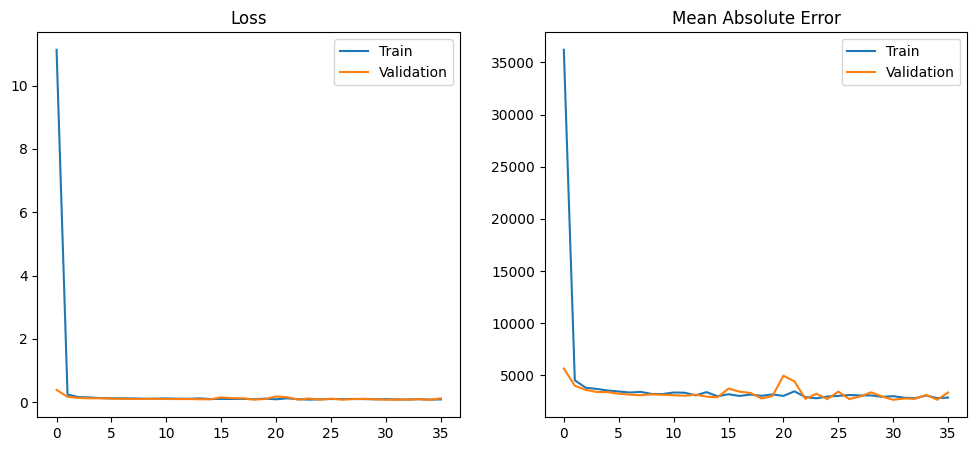

In [51]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100
early_stopping_patience = 5

train_loss_history = []
train_mae_history = []
val_loss_history = []
val_mae_history = []

best_val_mae = float('inf')
best_model_state = None
no_improvement_epochs = 0

for epoch_i in range(num_epochs):
    print(f"Epoch {epoch_i + 1}/{num_epochs} :")
    train_loss = train_mae = train_batches = 0
    model_3.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model_3(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()


        # train_loss += loss.item()
        # train_mae += compute_mae(reference, prediction).item()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()

        train_batches += 1

    avg_train_loss = train_loss / train_batches
    avg_train_mae = train_mae / train_batches
    train_loss_history.append(avg_train_loss)
    train_mae_history.append(avg_train_mae)

    print("\tTrain loss:\t%.5f" % avg_train_loss)
    print("\tTrain MAE:\t%.5f" % avg_train_mae)

    # Validation
    val_loss = val_mae = val_batches = 0
    model_3.train(False)
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model_3(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            # val_loss += loss.item()
            # val_mae += compute_mae(reference, prediction).item()

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()

            val_batches += 1

    avg_val_loss = val_loss / val_batches
    avg_val_mae = val_mae / val_batches
    val_loss_history.append(avg_val_loss)
    val_mae_history.append(avg_val_mae)

    print("\tValidation loss:\t%.5f" % avg_val_loss)
    print("\tValidation MAE:\t%.5f" % avg_val_mae)

    # Early Stopping
    if avg_val_mae < best_val_mae:
        best_val_mae = avg_val_mae
        best_model_state = deepcopy(model_3.state_dict())

        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= early_stopping_patience:
            print("Early stopping triggered. Training stopped.")
            break

model_3.load_state_dict(best_model_state)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_history, label='Train')
plt.plot(val_mae_history, label='Validation')
plt.title('Mean Absolute Error')
plt.legend()

plt.show()


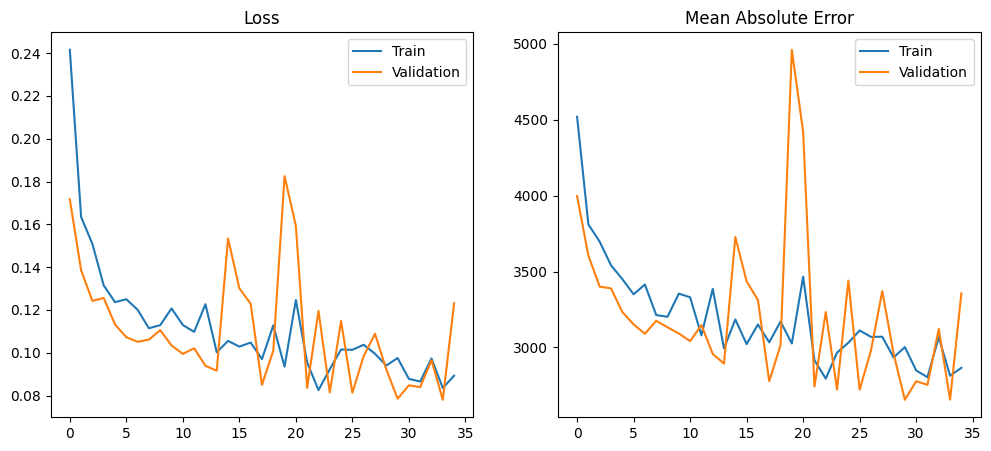

In [54]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history[1:], label='Train')
plt.plot(val_loss_history[1:], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_history[1:], label='Train')
plt.plot(val_mae_history[1:], label='Validation')
plt.title('Mean Absolute Error')
plt.legend()

plt.show()

In [53]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model_3(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction).to(device)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        #val_loss += loss.item()
        #val_mae += compute_mae(reference, prediction).item()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07851
	MAE:	2655.55314



